In [83]:
from DiGriFlex_RT import access_data_rt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import quantecon as qe
import scipy.stats as ss
plt.rcParams['figure.figsize']=(12,4)
plt.style.use('bmh')
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=20)

In [84]:
def transition_matrix(tran, ndig):
    n = 1 + ndig #number of states
    M1 = [[0] * n for _ in range(n)]
    for (i,j) in zip(tran,tran[1:]):
        M1[i][j] += 1
    #now convert to probabilities:
    k = 0
    for row in M1:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
        else:
            row[k] = 1
        k = k + 1
    return M1


def forecasting1(data0, name):
    date_sp = datetime.now()
    date_sp = date_sp.replace(day = date_sp.day + 1)
    t = pd.date_range(pd.Timestamp(date_sp).floor(freq ='D'), periods=144, freq='10min')
    plt.plot(t, np.transpose(data0))
    plt.ylabel(name, fontsize=18)
    plt.savefig('r1_' + name + '.pdf',bbox_inches='tight')
    plt.show()
    model = KMeans(n_clusters=3, random_state=0).fit(data0)
    output = model.cluster_centers_
    plt.plot(t, np.transpose(output))
    plt.legend(['Scenario 1', 'Scenario 2', 'Scenario 3'], fontsize=18)
    plt.ylabel(name, fontsize=18)
    plt.savefig('f1_' + name + '.pdf',bbox_inches='tight')
    plt.show()
    avg = np.average(output, axis=1)
    rank = ss.rankdata(avg)
    f_i = np.where(rank==2)
    forecast = output[f_i[0], :]
    err_p = np.max(output, axis=0) - forecast
    err_n = forecast - np.min(output, axis=0)
    vec_out = np.zeros((3, 144))
    vec_out[0, :] = forecast
    vec_out[1, :] = err_p
    vec_out[2, :] = err_n
    return vec_out


def forecasting2(data0, name):
    date_sp = datetime.now()
    date_sp = date_sp.replace(day = date_sp.day + 1)
    t = pd.date_range(pd.Timestamp(date_sp).floor(freq ='D'), periods=144, freq='10min')
    data0 = np.resize(data0, (dd * 144, 1))
    M = data0[288:]
    F = np.transpose(np.resize(np.array([data0[144:dd*144-144].tolist(),
                                         data0[:dd*144-288].tolist()]), (2, (dd - 2) * 144)))
    Theta = np.matmul(np.linalg.inv(np.matmul(np.transpose(F), F)), np.matmul(np.transpose(F), M))
    error = np.resize(M - np.matmul(F, Theta), (dd - 2, 144))
    varm = np.zeros((144, 1))
    for tt in range(144):
        varm[tt] = np.std(error[:, tt])
    F = np.transpose(np.resize(np.array([data0[dd*144-144:].tolist(),
                                         data0[dd*144-288:dd*144-144].tolist()]), (2, 144)))
    y_pred = np.matmul(F, Theta)
    plt.plot(t, y_pred)
    y_scen = np.zeros((100, 144))
    for s in range(100):
        for tt in range(144):
            y_scen[s, tt] = y_pred[tt] + np.random.normal(0, varm[tt])
    plt.plot(t, np.transpose(y_scen))
    plt.show()
    model = KMeans(n_clusters=3, random_state=0).fit(y_scen)
    output = model.cluster_centers_
    output = np.delete(output, model.predict(np.transpose(y_pred)), 0)
    output = np.append(output, np.transpose(y_pred), axis=0)
    plt.plot(t, np.transpose(output))
    plt.legend(['Scenario 1', 'Scenario 2', 'Scenario 3'], fontsize=18)
    plt.ylabel(name, fontsize=18)
    plt.savefig('f2_' + name + '.pdf',bbox_inches='tight')
    plt.show()
    err_p = np.max(output, axis=0) - np.transpose(y_pred)
    err_n = np.transpose(y_pred) - np.min(output, axis=0)
    vec_out = np.zeros((3, 144))
    vec_out[0, :] = np.transpose(y_pred)
    vec_out[1, :] = err_p
    vec_out[2, :] = err_n
    return vec_out


def forecasting3(data0, name):
    date_sp = datetime.now()
    date_sp = date_sp.replace(day = date_sp.day + 1)
    t = pd.date_range(pd.Timestamp(date_sp).floor(freq ='D'), periods=144, freq='10min')
    data1 = np.resize(data0, (dd * 144, 1))
    data = pd.DataFrame(data1, columns=['output'])
    for tt in range(144, 184):
        data[str(tt) + 'h_delay'] = data['output'].shift(periods=tt)
    std = np.std(data1) / data['output'].std()
    mean = np.mean(data1) - data['output'].mean()
    y = data.pop('output')
    train_x, train_y = data, y
    train_x = train_x.fillna(train_x.mean())
    features = list(train_x.columns)
    RandomForestRegModel = RandomForestRegressor()
    RandomForestRegModel.fit(train_x, train_y)
    y_pred = RandomForestRegModel.predict(train_x)
    y_pred = y_pred * std + mean
    y_pred0 = y_pred[-144:]
    plt.plot(t, y_pred0)
    plt.show()
    model = KMeans(n_clusters=3, random_state=0).fit(data0)
    ind = model.predict(np.resize(y_pred0, (1, 144)))
    ind2 = model.predict(data0)
    y = np.transpose(data0[ind2==ind])
    b = np.min(y)
    l = np.max(y) - np.min(y)
    y2 = np.divide(y - b, l)
    y2 = np.resize(np.transpose(y2), (y2.shape[1]*144, 1))
    y2 = y2[y2>0.01]
    plt.plot(y2)
    digit = 20
    bins = np.arange(0.05, 1, 1/digit)
    transitions = np.digitize(y2, bins, right=True)
    TM = transition_matrix(transitions,digit)
    fig, ax = plt.subplots()
    im = ax.imshow(TM)
    plt.show()
    mc = qe.MarkovChain(TM)
    y_scen = np.zeros((100, 144))
    for s in range(100):
        if name == 'PV power production (kW)':
            l = np.max(y, axis=1) - np.min(y, axis=1)
            b = 0
            initial_state = 0
        else:
            l = np.max(y) - np.min(y)
            b = np.min(y)
            initial_state = digit / 2
        X = mc.simulate(init = int(initial_state), ts_length=144) / (np.sqrt(np.size(TM))-1)

        y_scen[s, :] = np.multiply(X, l) + b
    plt.plot(t, np.transpose(y_scen))
    plt.show()
    model = KMeans(n_clusters=3, random_state=0).fit(y_scen)
    output = model.cluster_centers_
    delind = model.predict(np.resize(y_pred0, (1, 144)))
    output = np.delete(output, delind, 0)
    output = np.append(output, np.resize(y_pred0, (1, 144)), axis=0)
    plt.plot(t, np.transpose(output))
    plt.legend(['Scenario 1', 'Scenario 2', 'Scenario 3'], fontsize=18)
    plt.ylabel(name, fontsize=18)
    plt.savefig('f3_' + name + '.pdf',bbox_inches='tight')
    plt.show()
    err_p = np.max(output, axis=0) - y_pred0
    err_n = y_pred0 - np.min(output, axis=0)
    vec_out = np.zeros((3, 144))
    vec_out[0, :] = np.transpose(y_pred0)
    vec_out[1, :] = np.transpose(err_p)
    vec_out[2, :] = np.transpose(err_n)
    return vec_out

In [85]:
data_rt = access_data_rt()
dd = 30
t_end = data_rt.index[-1].floor('1d') - timedelta(hours=1)
t_from = t_end - timedelta(days=dd) + timedelta(minutes=10)
pv_pred_da = np.resize(data_rt['P'][t_from:t_end].to_numpy(), (dd, 144)) / 1000
Pdem_pred_da = np.resize(data_rt['Pdem'][t_from:t_end].to_numpy(), (dd, 144)) / 10
Qdem_pred_da = np.resize(data_rt['Qdem'][t_from:t_end].to_numpy(), (dd, 144)) /10

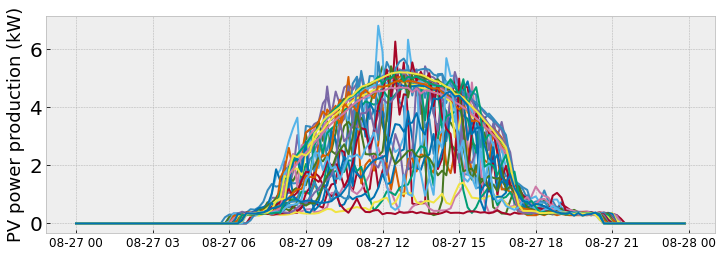

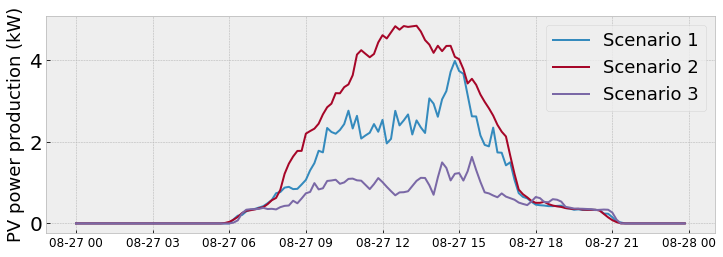

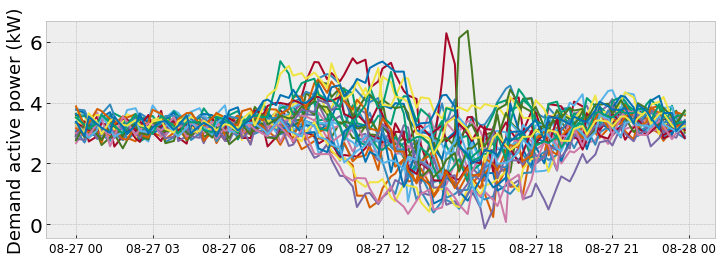

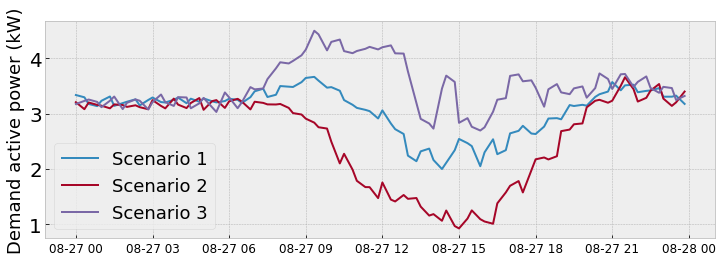

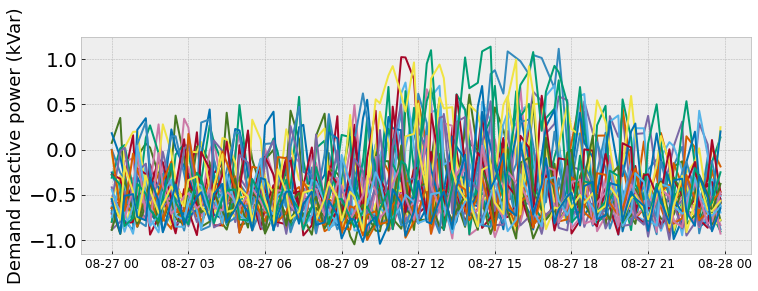

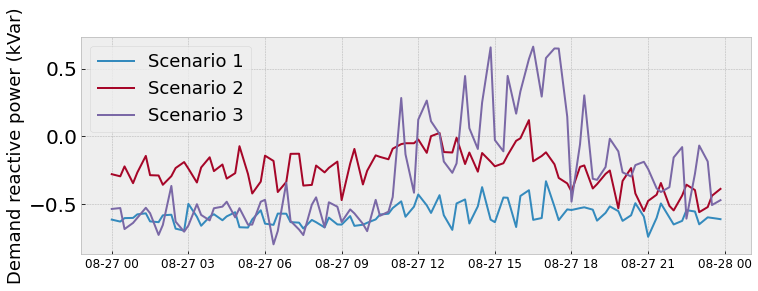

In [86]:
pv_out1 = forecasting1(pv_pred_da, 'PV power production (kW)')
Pdem_out1 = forecasting1(Pdem_pred_da, 'Demand active power (kW)')
Qdem_out1 = forecasting1(Qdem_pred_da, 'Demand reactive power (kVar)')

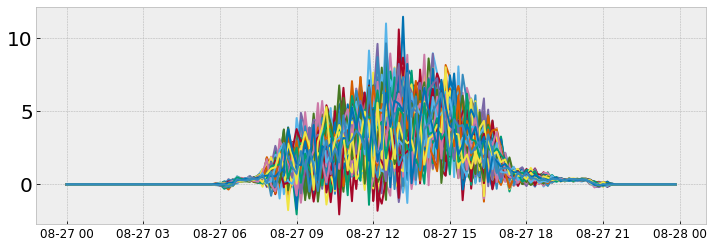

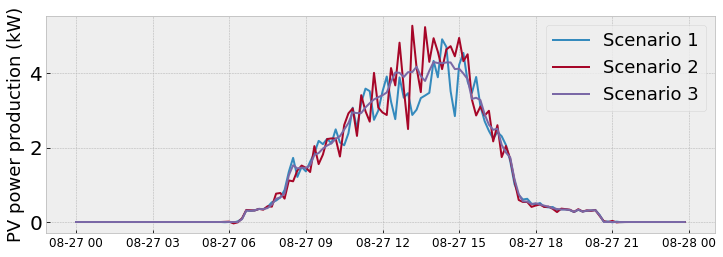

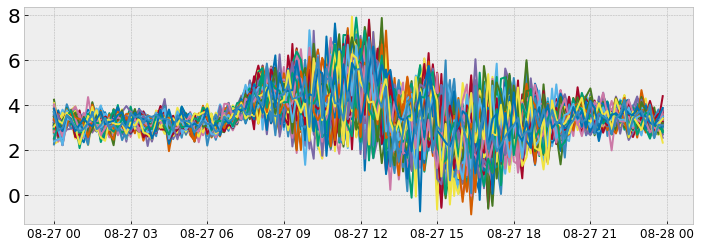

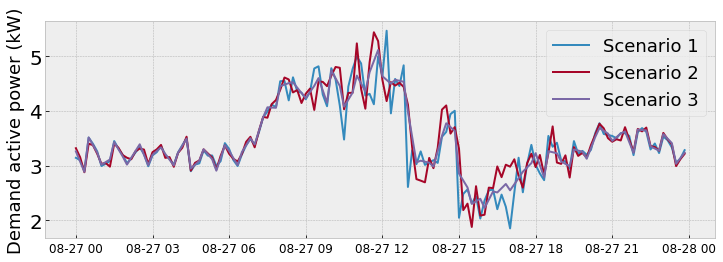

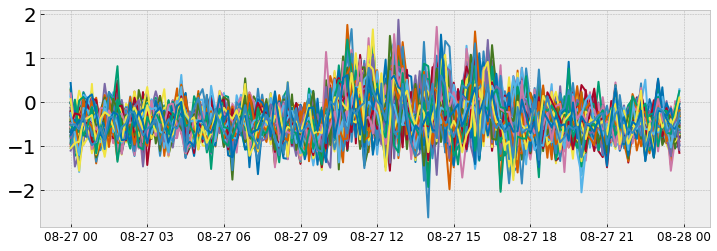

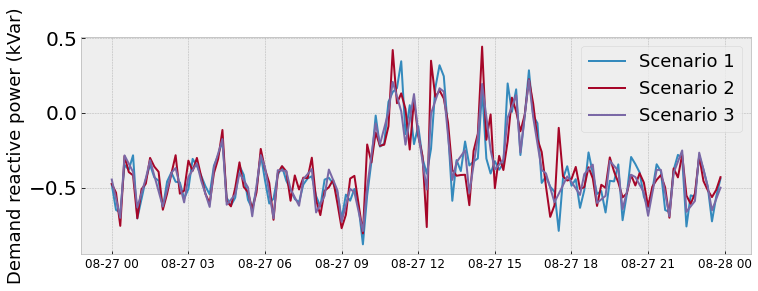

In [87]:
pv_out2 = forecasting2(pv_pred_da, 'PV power production (kW)')
Pdem_out2 = forecasting2(Pdem_pred_da, 'Demand active power (kW)')
Qdem_out2 = forecasting2(Qdem_pred_da, 'Demand reactive power (kVar)')

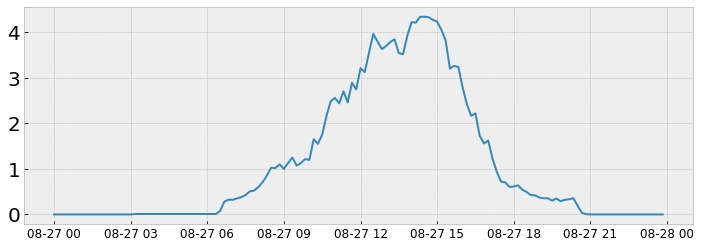

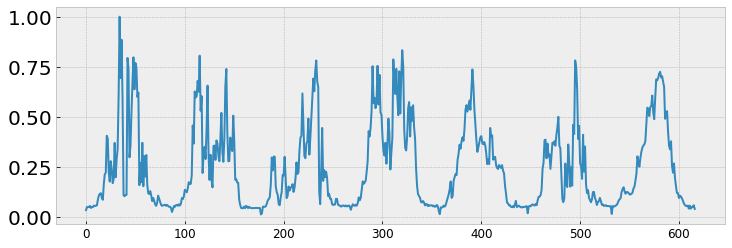

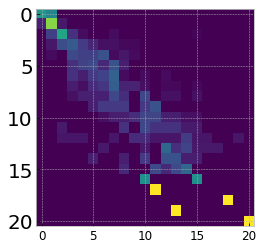

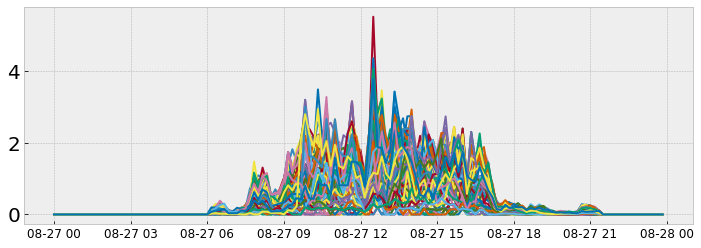

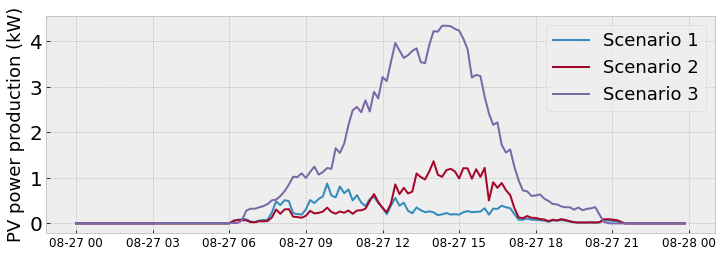

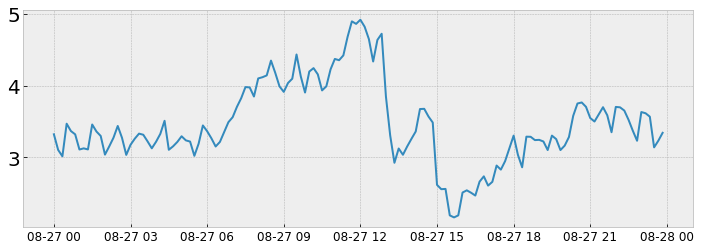

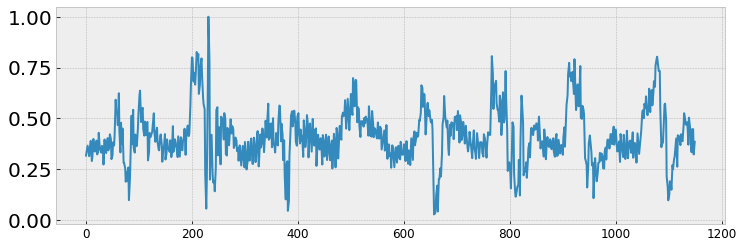

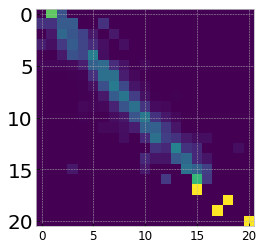

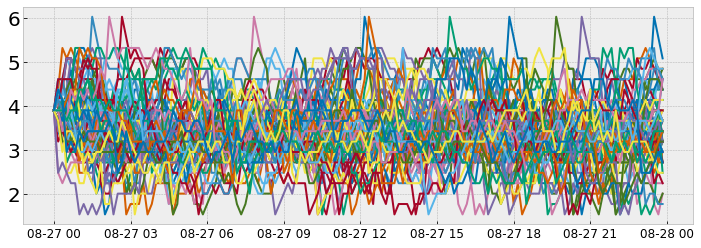

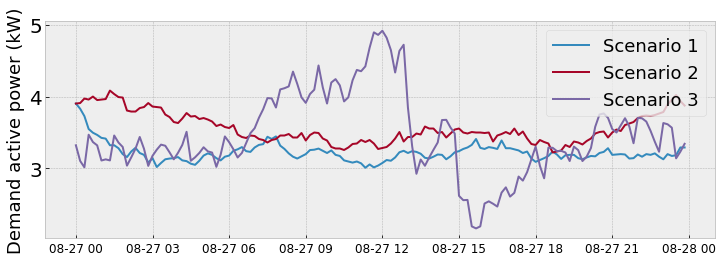

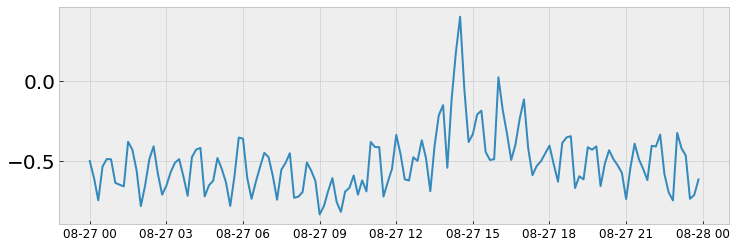

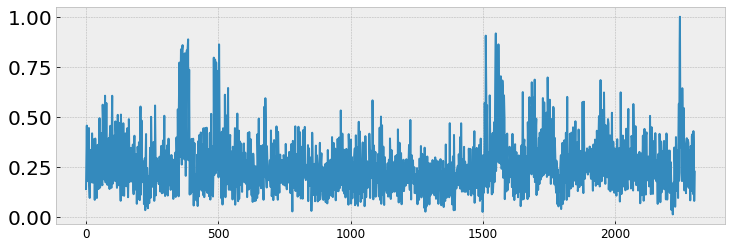

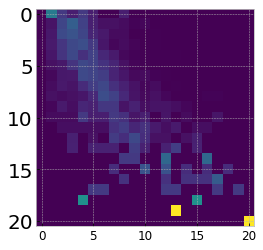

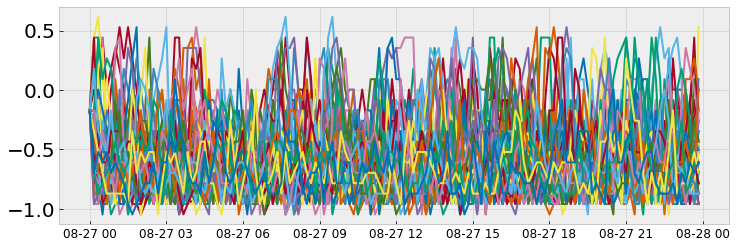

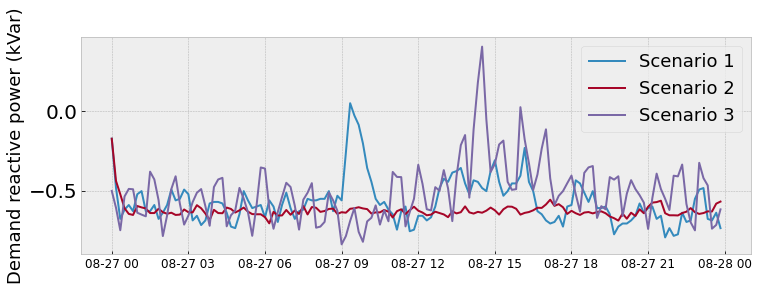

In [88]:
pv_out3 = forecasting3(pv_pred_da, 'PV power production (kW)')
Pdem_out3 = forecasting3(Pdem_pred_da, 'Demand active power (kW)')
Qdem_out3 = forecasting3(Qdem_pred_da, 'Demand reactive power (kVar)')
